# Supervised WSD
1.   Training data consists of words tagged in context with their senses
2.   Train per-word classifiers that can tag words in a new unseen data

*   Dictionary as an inventory of sense
*   Training+Test data
*   Feature extraction from a text
*   Statistical model


In [ ]:
import re,pickle,pprint
import numpy as np
import pandas as pd
import math, time
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from operator import *
from functools import reduce
import re, string
from string import digits 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Preprocessing

## Dataset cleanup
Clean up the training, validation and test data

In [ ]:
lemma = WordNetLemmatizer()
def clean_words(words):
  return [lemma.lemmatize(word) for word in words if (re.match('.*\w+.*',word) != None) and (word not in stopwords.words('english'))]

In [ ]:
def clean_data(source, output):
  with open(source) as s:
    with open(output,'w') as o:
      for line in s:
        [word,meaning,prev,actual,after] = re.compile('\||%%').split(line)
        # Turn prev and after into a list of words
        prev = ' '.join(clean_words(prev.strip().lower().split(' ')))
        after = ' '.join(clean_words(after.strip().lower().split(' ')))
        o.write(word + "|" + meaning + "|" + prev + "%%" + actual + "%%" + after + "\n")

In [ ]:
clean_data('train.data', 'train_clean.data')
clean_data('test.data', 'test_clean.data')
clean_data('validate.data', 'validate_clean.data')

In [ ]:
def rename_columns(dataset):
  rename = dataset.rename(columns = {0:'Target_Word', 1:'Sense_ID', 2:'Context'})
  rename = rename.reset_index(drop=True)
  return rename

In [ ]:
df_train = pd.read_csv (r'train_clean.data',header=None,delimiter = "|")
#uncomment when combining train dataset with validation for test prediction
#df_train=df_train.reset_index()
df_test = pd.read_csv (r'test_clean.data',header=None,delimiter = "|")
df_test = df_test.reset_index()
df_val = pd.read_csv (r'validate_clean.data',header=None,delimiter = "|")
df_val = df_val.reset_index()

In [ ]:
train_sp = rename_columns(df_train)
test_sp = rename_columns(df_test)
val_sp = rename_columns(df_val)

In [ ]:
test_sp = test_sp.rename(columns = {'index':"Unique_ID"})
val_sp = val_sp.rename(columns = {'index':"Unique_ID"})

In [ ]:
train_sp['Target_Word'] = train_sp.Target_Word.str.replace(' ', '') 
test_sp['Target_Word'] = test_sp.Target_Word.str.replace(' ', '') 
val_sp['Target_Word'] = val_sp.Target_Word.str.replace(' ', '')

# Baseline Model
predicts the most frequent sense

In [ ]:
baseline_sp = val_sp
#retrieve list of unique target words from validation data
TargetWords = baseline_sp['Target_Word'].value_counts()
TargetWords = pd.DataFrame(TargetWords)
TargetWords = TargetWords.reset_index()
TargetWords.columns = ['Words','Count']
targets = TargetWords.Words.tolist()
# empty dataframe to store predictions
Predictions = pd.DataFrame(columns=['Predicted_Sense_ID','Predicted_Sense','Actual_Sense_ID','Unique_ID'])

In [ ]:
# test on validation data

cnt = 1
for target_word in targets:
  cnt += 1            
  test_word = val_sp.loc[val_sp['Target_Word'] == target_word]
  test_word = test_word.reset_index()
                  
  unique_ids = test_word['Unique_ID'].tolist()
  actual_sense = test_word['Sense_ID'].tolist()
                  
  #Training_dict,PriorProb=CreateMyTrainData(df_train,target_word)
  train_word = train_sp.loc[train_sp['Target_Word']==target_word]

  senses = pd.DataFrame(train_word.Sense_ID.value_counts())
  senses = senses.reset_index()

  #assign mode of the sense_id as a prediction of the target word
  predicted = senses[senses.Sense_ID == senses.Sense_ID.max()]['index'].tolist()[0]

  k=0
  for sent in test_word['Context']:
    append_sp = [predicted, sent,actual_sense[k],unique_ids[k]]
    k+=1
    df_length = len(Predictions)
    Predictions.loc[df_length] = append_sp


# Accuracy = # of correct predictions / # of total predictions
Predictions['Acc']= (Predictions.Predicted_Sense_ID == Predictions.Actual_Sense_ID)
baseline_accuracy = Predictions['Acc'].value_counts()/len(Predictions['Acc'])
print("Baseline accuracy is %s",str(baseline_accuracy[1]))

Baseline accuracy is %s 0.8113612004287245


# Naive Bayes Model

*   Inference model: ouput statistically the most possible sense
*   Simplest probabilistic model

P (si) = count(si, w)/count(w)

P (fj |si) = count(fj , si)/count(si)

In [ ]:
# for co-occurrence feature: how many times the word appears
simple_cnt = lambda word,i,count: count + 1

## Generate Feature Vector

In [ ]:
def feature_extract(data='training_clean.data',window_size=-1,colocation=True,co_occurrence=True,co_counts=simple_cnt):
  max_after = []
  max_prev = []
  reg = []
  with open(data) as f:
    for line in f:            
        [word,sense,prev,target,after] = re.compile('\||%%').split(line)
        [word,pos] = word.split('.')
        prev = prev.strip().lower().split(' ')
        prev.reverse()
        after = after.strip().lower().split(' ')
        max_after.append(len(after))
        max_prev.append(len(prev))
        if window_size != -1:
          prev = prev[:window_size]
          after = after[:window_size]
        features = dict()
        length = window_size if window_size != -1 else max(len(prev),len(after))
        for i in range(length):
          if i < len(prev):
            if co_occurrence:
              #Compute co-occurrence features for previous window
              prev_entry = prev[i]
              if prev_entry in features:
                features[prev_entry] = co_counts(prev[i],i,features[prev_entry])
              else: 
                features[prev_entry] = co_counts(prev[i],i,0)
            if colocation:
              #Compute co-locational features
              features[('prev',i+1)] = prev[i]
              text = word_tokenize(prev[i])
              tag = pos_tag(text)
              if len(tag) != 0:
                features[('prev-pos',i+1)] = tag[0][1]
          if i < len(after):
            if co_occurrence:
              #Compute co-occurence features for after window
              after_entry = after[i]
              if after_entry in features:
                  features[after_entry] = co_counts(after[i],i,features[after_entry])
              else: 
                  features[after_entry] = co_counts(after[i],i,0)
            if colocation:
              #Compute co-locational features
              features[('after',i+1)] = after[i]
              text = word_tokenize(after[i])
              tag = pos_tag(text)
              if len(tag) != 0:
                features[('after-pos',i+1)] = tag[0][1]
        example = (word.strip(),int(sense.strip()),features)
        reg.append(example)
  return reg

In [ ]:
# output the most probable sense
def argmax(pairs):
  return max(pairs, key=itemgetter(1))[0]

## Model Construction

P (si) = count(si, w)/count(w)

P (fj |si) = count(fj , si)/count(si)

##  use the log of probability to avoid underflow

The probability values are in [0, 1]. Hence multiplying two or more such small numbers could easily lead to an underflow in a floating point precision arithmetic (e.g. consider multiplying 0.0001*0.00001). A practical solution is to use the logs to get rid of the underflow.

In [ ]:
class Supervised_WSD():
  def __init__(self, traindata, max_eg=-1):
    self.sense_cnt = dict()
    self.word_cnt = dict()
    self.feature_cnt = dict()
    self.featurelists = dict()
    # Generating necessary counts
    for example in traindata:
      word = example[0]
      sense = example[1]
      features = example[2]
      if (max_eg == -1) or (word not in self.word_cnt) or (sense not in self.sense_cnt[word]) or (max_eg != -1 and max_eg > self.sense_cnt[word][sense]):
        if word in self.word_cnt:
          self.word_cnt[word] += 1
        else:
          self.word_cnt[word] = 1
        if word in self.sense_cnt:
          if sense in self.sense_cnt[word]:
            self.sense_cnt[word][sense] += 1
          else:
            self.sense_cnt[word][sense] = 1
        else:
          self.sense_cnt[word] = dict()
          self.sense_cnt[word][sense] = 1
        for key,value in features.items():
          if word not in self.featurelists:
            self.featurelists[word] = set()
          self.featurelists[word].add(key)
          if (word, sense) in self.feature_cnt:
            if key in self.feature_cnt[(word,sense)]:
              if value in self.feature_cnt[(word,sense)][key]:
                self.feature_cnt[(word,sense)][key][value] += 1
              else:
                self.feature_cnt[(word,sense)][key][value] = 1
            else:
              self.feature_cnt[(word,sense)][key] = dict()
              self.feature_cnt[(word,sense)][key][value] = 1
          else:
              self.feature_cnt[(word,sense)] = dict()
              self.feature_cnt[(word,sense)][key] = dict()
              self.feature_cnt[(word,sense)][key][value] = 1

  # k: add-k smoothing
  def classifier(self,testdata,k=1,softscore=False):
      predictions = []
      actual = []
      correct = 0
      for example in testdata:
          word = example[0]
          actual.append(example[1])
          features = example[2]
          probs = []
          if word in self.word_cnt:
              wc = self.word_cnt[word]
              for sense in self.sense_cnt[word]:
                  sc = self.sense_cnt[word][sense]
                  prob = 0.0
                  if word in self.featurelists:
                      for key in self.featurelists[word]:
                          fp = 0.0
                          if key in features:
                              value = features[key]
                              if key in self.feature_cnt[(word,sense)]:
                                  #Are there any of the value in this test example in our training examples
                                  if value in self.feature_cnt[(word,sense)][key]:
                                      fp = math.log((self.feature_cnt[(word,sense)][key][value] + k) / float(sc+k*len(self.featurelists[word])))
                                  #if not, use add one smoothing to avoid zero probability
                                  else:
                                      fp = math.log(k/float(sc+k*len(self.featurelists[word])))
                              #If it doesn't then using add 1 smoothing compute probability
                              else:
                                  fp = math.log(k/float(sc+k*len(self.featurelists[word])))
                          # feature is 0/null in example
                          else:
                              if key in self.feature_cnt[(word,sense)]:
                                  fp = math.log((sc-sum(self.feature_cnt[(word,sense)][key].values())+k) / float(sc+k*len(self.featurelists[word])))
                              else:
                                  fp = math.log((sc + k) / float(sc+k*len(self.featurelists[word])))
                          prob += fp
                  probs.append((sense,prob))
              res = None
              if softscore == True:
              # separate out the senses and the probabilities into 2 lists
                senses = [item[0] for item in probs]
                prob_numbers = [item[1] for item in probs]
                # senses = list(zip(*probs)[0])
                # prob_numbers = list(zip(*probs)[1])
                #Adjust probabilities by maximum log to avoid underflow if possible when normalizing. 
                m_log = max(prob_numbers)
                prob_numbers = [math.e**(x-m_log) for x in prob_numbers]
                prob_sum = sum(prob_numbers)
                prob_numbers = [x/prob_sum for x in prob_numbers]
                probs = list(zip(senses, prob_numbers))
                res = argmax(probs)
                probs = dict(probs)
                if example[1] in probs:
                  correct = correct if res != example[1] else correct+1
              else:
                  res = argmax(probs)
                  correct = correct if res != example[1] else correct+1
              predictions.append(res)
          else:
              predictions.append(-1)
      accuracy = correct/float(len(predictions))
      return (accuracy,zip(actual,predictions))

  def statistics(self):
    print(np.median(self.wordCounts.values()))
    print(max(self.wordCounts.values()))
    print(np.mean(self.wordCounts.values()))
    print(min(self.wordCounts.values()))

# Hard-Score

## Size of window: 1-100 with add 1/ add k smoothing

## Add 1

In [ ]:
def hard_scoring():
  windows = [1,10,30,50,70,90,100]
  with open('hard-scoring-compare.csv','a') as f:
    for i in windows:
      start = time.time()
      nb_coo = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i,co_occurrence=True,colocation=False))
      res_coo = nb_coo.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=True,colocation=False))
      nb_col = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i, co_occurrence=False,colocation=True))
      res_col = nb_col.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=False,colocation=True))
      f.write(str(i) + "," + str(res_coo[0]) + "," + str(res_col[0]) + "\n")
      f.flush()

In [ ]:
hard_compare = hard_scoring()

In [ ]:
hard_compare_plot = pd.read_csv (r'hard-scoring-compare.csv',header=None)
windowsize = hard_compare_plot[0].tolist()
coo = hard_compare_plot[1].tolist()
col = hard_compare_plot[2].tolist()

In [ ]:
hard_compare_plot = hard_compare_plot.rename(columns = {0:'Windowsize', 1:'Co_occurrence', 2:'Colocation'})
hard_compare_plot.to_csv('hard-scoring-compare-add1.csv')

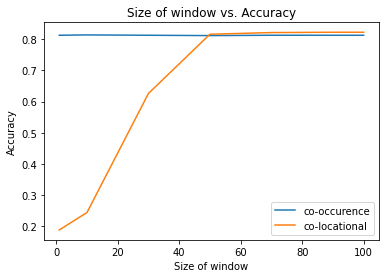

In [ ]:
import matplotlib.pyplot as plt

plt.plot(windowsize, coo, label='co-occurence')
plt.plot(windowsize, col, label='co-locational')
plt.title('Size of window vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Size of window')
plt.legend()
plt.show()

## Add k

In [ ]:
def hard_scoring():
  windows = [1,10,30,50,70,90,100]
  k = [0.001,0.01,0.1,1]
  with open('hard-scoring-compare-addk.csv','a') as f:
    for i in windows:
      for j in k:
        start = time.time()
        nb_coo = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i,co_occurrence=True,colocation=False))
        res_coo = nb_coo.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=True,colocation=False),k=j)
        nb_col = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i, co_occurrence=False,colocation=True))
        res_col = nb_col.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=False,colocation=True),k=j)
        f.write(str(i) + "," + str(j) + "," + str(res_coo[0]) + "," + str(res_col[0]) + "\n")
        f.flush()

In [ ]:
hard_compare_addk = hard_scoring()

In [ ]:
hard_comparek_plot = pd.read_csv (r'hard-scoring-compare-addk.csv',header=None)
windowsize_hardk = hard_comparek_plot[0].tolist()
coo_hardk = hard_comparek_plot[1].tolist()
col_hardk = hard_comparek_plot[2].tolist()

In [ ]:
hard_comparek_plot = hard_comparek_plot.rename(columns = {0:'Windowsize',1:'Add-k-smoothing', 2:'Co_occurrence', 3:'Colocation'})
hard_comparek_plot.to_csv('hard-scoring-compare-addk.csv')

In [ ]:
hard_addk =pd.read_csv (r'hard-scoring-compare-addk.csv',header=None)

In [ ]:
hard_addk = hard_addk.iloc[1:]

In [ ]:
hard_coo = hard_addk[3].tolist()

In [ ]:
hard_coo_addk = []
for i in hard_coo:
  i = float(i)
  i = '%.2f' % i
  hard_coo_addk.append(i)

In [ ]:
hard_col = hard_addk[4].tolist()

In [ ]:
hard_col_addk = []
for i in hard_col:
  i = float(i)
  i = '%.2f' % i
  hard_col_addk.append(i)

In [ ]:
windowsize_hard_add = hard_addk[1].tolist()

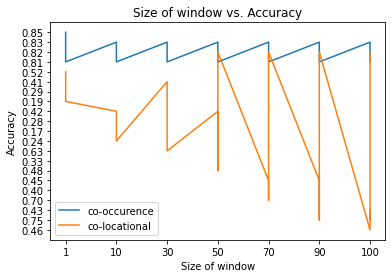

In [ ]:
import matplotlib.pyplot as plt
plt.plot(windowsize_hard_add, hard_coo_addk, label='co-occurence')
plt.plot(windowsize_hard_add, hard_col_addk, label='co-locational')
plt.title('Size of window vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Size of window')
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.show()

# Soft-scoring

## Size of window: 1-100 with add 1/ add k smoothing

## Add 1

In [ ]:
def soft_scoring():
  windows = [1,10,30,50,70,90,100]
  with open('soft-scoring-compare.csv','a') as f:
    for i in windows:
      start = time.time()
      nb_coo = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i,co_occurrence=True,colocation=False))
      res_coo = nb_coo.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=True,colocation=False), softscore=True)
      nb_col = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i, co_occurrence=False,colocation=True))
      res_col = nb_col.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=False,colocation=True), softscore=True)
      f.write(str(i) + "," + str(res_coo[0]) + "," + str(res_col[0]) + "\n")
      f.flush()

In [ ]:
soft_compare = soft_scoring()

In [ ]:
soft_compare_plot = pd.read_csv (r'soft-scoring-compare.csv',header=None)
windowsize_soft = soft_compare_plot[0].tolist()
coo_soft = soft_compare_plot[1].tolist()
col_soft = soft_compare_plot[2].tolist()

In [ ]:
soft_compare_add_plot = soft_compare_plot.rename(columns = {0:'Windowsize', 1:'Co_occurrence', 2:'Colocation'})
soft_compare_add_plot.to_csv('soft-scoring-compare-addk.csv')

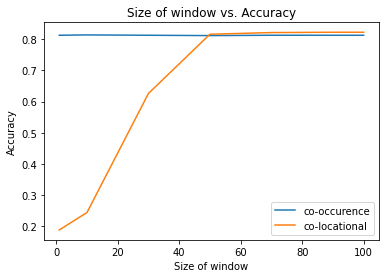

In [ ]:
plt.plot(windowsize_soft, coo_soft, label='co-occurence')
plt.plot(windowsize_soft, col_soft, label='co-locational')
plt.title('Size of window vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Size of window')
plt.legend()
plt.show()

## Add-k

In [ ]:
def soft_scoring():
  windows = [1,10,30,50,70,90,100]
  k = [0.001,0.01,0.1,1]
  with open('soft-scoring-compare-addk.csv','a') as f:
    for i in windows:
      for j in k:
        start = time.time()
        nb_coo = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i,co_occurrence=True,colocation=False))
        res_coo = nb_coo.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=True,colocation=False),k=j,softscore=True)
        nb_col = Supervised_WSD(feature_extract(data='train_clean.data', window_size=i, co_occurrence=False,colocation=True))
        res_col = nb_col.classifier(feature_extract(data='validate_clean.data', window_size=i,co_occurrence=False,colocation=True),k=j,softscore=True)
        f.write(str(i) + "," + str(j) + "," + str(res_coo[0]) + "," + str(res_col[0]) + "\n")
        f.flush()

In [ ]:
soft_compare_addk = soft_scoring()

In [ ]:
soft_compare_addk_plot = pd.read_csv (r'soft-scoring-compare-addk.csv',header=None)
windowsize_soft_add = soft_compare_addk_plot[0].tolist()
coo_soft_add = soft_compare_addk_plot[3].tolist()
col_soft_add = soft_compare_addk_plot[4].tolist()

In [ ]:
soft_compare_addk_plot = soft_compare_addk_plot.rename(columns = {0:'Windowsize', 1:'Add_k_smoothing', 2:'Co_occurrence', 3:'Colocation'})
soft_compare_addk_plot.to_csv('soft-scoring-compare-addk.csv')

In [ ]:
soft_addk =pd.read_csv (r'soft-scoring-compare-addk.csv',header=None)

In [ ]:
soft_addk = soft_addk.iloc[1:]

In [ ]:
soft_coo = soft_addk[3].tolist()

In [ ]:
soft_coo_addk = []
for i in soft_coo:
  i = float(i)
  i = '%.2f' % i
  soft_coo_addk.append(i)

In [ ]:
soft_col = soft_addk[4].tolist()

In [ ]:
soft_col_addk = []
for i in soft_col:
  i = float(i)
  i = '%.2f' % i
  soft_col_addk.append(i)

In [ ]:
windowsize_soft_add = soft_addk[1].tolist()

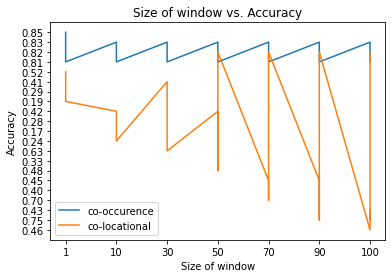

In [ ]:
import matplotlib.pyplot as plt
plt.plot(windowsize_soft_add, soft_coo_addk, label='co-occurence')
plt.plot(windowsize_soft_add, soft_col_addk, label='co-locational')
plt.title('Size of window vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Size of window')
ax = plt.gca()
ax.invert_yaxis()
plt.legend()
plt.show()